In [1]:
from collections import defaultdict as ddict
import dill
from glob import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
from pprint import pprint
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
import seaborn as sns
import sys; sys.path.append('../')
from tqdm import tqdm

import torch
from torch_geometric.utils import *


from dataloading_utils import load_dataset, load_deprels
from experiment_configs import model_configurations

In [2]:
experiment_config       = 'dep_residual'
spl_dict                = ddict(lambda: ddict(int))

for dataset in ['mscorpus','japflow','risec']:

    configuration       = model_configurations[experiment_config]

    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    elem = dataset_loaded['train']['rels'][0]

    for elem in tqdm(dataset_loaded['train']['rels']):
        depgraph_data = elem['dep_data']
        n1_mask, n2_mask = depgraph_data.n1_mask, depgraph_data.n2_mask


        if n1_mask.sum().item() ==1:
            n1_ids  = [(n1_mask==1).nonzero().item()]
        elif n1_mask.sum().item() > 1:
            n1_ids  = list(np.array((n1_mask==1).nonzero().squeeze()))

        if n2_mask.sum().item() ==1:
            n2_ids  = [(n2_mask==1).nonzero().item()]
        elif n2_mask.sum().item() > 1:
            n2_ids = list(np.array((n2_mask==1).nonzero().squeeze()))

        graph =  to_networkx(depgraph_data)
        # print(graph.nodes(), graph.edges())
        assert len(graph.nodes()) == len(graph.edges())+1

        graph = graph.to_undirected()

        # print(n1_ids)
        # print(n2_ids)

        spls  =  []
        for n1 in n1_ids:
            for n2 in n2_ids:
                try:
                    spl = nx.shortest_path_length(graph, n1, n2)
                    spls.append(spl)
                except Exception as e:
                    continue
            
        spl_dict[dataset][min(spls)]+=1


100%|██████████| 3689/3689 [00:04<00:00, 742.85it/s] 


## Distribution of dependency distance between the entities

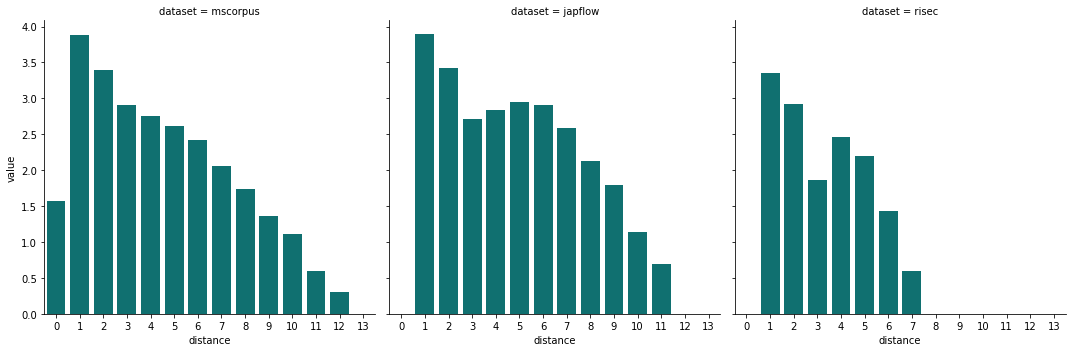

In [3]:
split_dict = ddict(list)

import math

for dataset in spl_dict:
    for dist in spl_dict[dataset]:
        split_dict['dataset'].append(dataset)
        split_dict['distance'].append(dist)
        split_dict['value'].append(math.log(spl_dict[dataset][dist])/math.log(10))

split_df  = pd.DataFrame(split_dict)

sequential_colors = sns.color_palette("RdPu", 1)

g=sns.catplot(data=split_df, x="distance", y="value", col="dataset",kind="bar", color='teal') 

plt.show()

## How many ent-ent dependency pairs are there for each dataset

In [18]:
experiment_config   = 'dep_residual'
analysis_dict       = ddict(lambda: ddict(list))
configuration       = model_configurations[experiment_config]

deprel_dict         = load_deprels()
id2deprels          = [dep for dep in deprel_dict]

for dataset in ['mscorpus','japflow','risec']:
    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    for elem in tqdm(dataset_loaded['train']['rels']):
        depgraph_data = elem['dep_data']
        n1_mask, n2_mask = depgraph_data.n1_mask, depgraph_data.n2_mask

        if n1_mask.sum().item() ==1:
            n1_ids  = [(n1_mask==1).nonzero().item()]
        elif n1_mask.sum().item() > 1:
            n1_ids  = list(np.array((n1_mask==1).nonzero().squeeze()))

        if n2_mask.sum().item() ==1:
            n2_ids  = [(n2_mask==1).nonzero().item()]
        elif n2_mask.sum().item() > 1:
            n2_ids = list(np.array((n2_mask==1).nonzero().squeeze()))

        graph =  to_networkx(depgraph_data)
        # print(graph.nodes(), graph.edges())
        assert len(n1_ids) >0 and len(n2_ids) > 0
        assert len(graph.nodes()) == len(graph.edges())+1

        ugraph = graph.to_undirected()
        assert len(ugraph.nodes()) == len(ugraph.edges())+1
        
        
        spls  =  []
        for n1 in n1_ids:
            for n2 in n2_ids:
                spl = nx.shortest_path_length(ugraph, n1, n2)
                spls.append((spl, n1, n2))
            
        spl_val, n1, n2 = min(spls)
        
        if spl_val != 1: continue
        
        n_ids   = list(n1_ids)
        n_ids.extend(n2_ids)
        
        dep = None
        for i in range(0, len(depgraph_data.edge_type)):
            if depgraph_data.edge_index[0][i] in n_ids and depgraph_data.edge_index[1][i] in n_ids :
                dep = id2deprels[depgraph_data.edge_type[i]]
        
        assert dep is not None
        
        
        ent1_type, ent2_type = elem['span_info'][3], elem['span_info'][7]
                
        analysis_dict[dataset][(ent1_type, ent2_type, dep)].append({'span_info': elem['span_info'],\
            'sent': elem['sent'], 'sent_start': elem['sent_start']})
        

100%|██████████| 3689/3689 [00:07<00:00, 524.31it/s]


In [139]:
all_possible_tups = ddict(lambda: ddict(int))

for dataset in ['mscorpus','japflow','risec']:
    dataset_loaded      = load_dataset(configuration["base_path"], dataset)

    for elem in tqdm(dataset_loaded['train']['rels']):
        e1_type, e2_type = elem['span_info'][3], elem['span_info'][7]
        all_possible_tups[dataset][(e1_type, e2_type)]+=1

print("All Possible relations")
for dataset in all_possible_tups:
    print(dataset, len(all_possible_tups[dataset]))

print("Relations with only 1 dependency distance between them")

for dataset in ['mscorpus','risec','japflow']:
    print(dataset, len(analysis_dict[dataset]))

100%|██████████| 3689/3689 [00:00<00:00, 495160.89it/s]

All Possible relations
mscorpus 35
japflow 76
risec 8
Relations with only 1 dependency link between them
mscorpus 155
risec 20
japflow 219


In [23]:
for tup in analysis_dict['risec']:
    if len(analysis_dict['risec'][tup]) < 5: continue
    
    out_file = open(f'dep_risec/risec_{tup}.txt','w')
    
    for elem in analysis_dict['risec'][tup]:
        sent       = elem['sent']
        sent_start = elem['sent_start']
        sent_end   = len(elem['sent'])
        
        e1_start, e1_end, e2_start, e2_end = elem['span_info'][0]-sent_start, elem['span_info'][1] - sent_start, elem['span_info'][4] - sent_start, elem['span_info'][5] - sent_start
        
        if e1_end < e2_start:
            new_sent = f'{sent[0:e1_start]}<E1>{sent[e1_start:e1_end]}</E1>{sent[e1_end:e2_start]}<E2>{sent[e2_start:e2_end]}</E2>{sent[e2_end:]}'
        
        if e2_end < e1_start:
            new_sent = f'{sent[0:e2_start]}<E2>{sent[e2_start:e2_end]}</E2>{sent[e2_end:e1_start]}<E1>{sent[e1_start:e1_end]}</E1>{sent[e1_end:]}'
        
        out_file.write('\n-------------------------------------------------------\n')    
        out_file.write(new_sent.strip())
        out_file.write('\n-------------------------------------------------------\n')
        print(sent)
        print(new_sent)    
        


1) In a saucepan over low heat, stir together the half-and-half and sugar.
1) In <E2>a saucepan</E2> over low heat, <E1>stir</E1> together the half-and-half and sugar.

3) Remove from heat and cool, then place in refrigerator and chill overnight.

3) Remove from heat and cool, then <E1>place</E1> in <E2>refrigerator</E2> and chill overnight.

5) Pour into prepared loaf pan.
6) Smooth top.

5) <E1>Pour</E1> into <E2>prepared loaf pan</E2>.
6) Smooth top.

11) Test with toothpick.
12) When inserted it should come out clean.
13) Remove bread from pan to rack to cool.

11) <E1>Test</E1> with <E2>toothpick</E2>.
12) When inserted it should come out clean.
13) Remove bread from pan to rack to cool.

12) When inserted it should come out clean.
13) Remove bread from pan to rack to cool.

12) When inserted it should come out clean.
13) <E1>Remove</E1> bread from <E2>pan</E2> to rack to cool.

12) When inserted it should come out clean.
13) Remove bread from pan to rack to cool.

12) When insert

In [119]:
analysis_dict['risec'].keys()

dict_keys([('AC', 'TOOL'), ('AC', 'FOOD'), ('AC', 'AC'), ('AC', 'CONDITION_CLAUSE'), ('AC', 'OTHER'), ('AC', 'DUR'), ('AC', 'TEMPERATURE'), ('AC', 'PURPOSE_CLAUSE')])

In [17]:
gdata = dataset_loaded['train']['rels'][0]['dep_data']

graph =  to_networkx(gdata, to_undirected=True)

src_idx  = gdata.n1_mask.index(1)


print(graph)

DiGraph with 22 nodes and 21 edges


In [19]:
graph.nodes()
graph.edges()

OutEdgeView([(1, 2), (2, 11), (3, 1), (4, 5), (5, 2), (6, 5), (7, 8), (8, 5), (9, 8), (10, 2), (11, 0), (12, 2), (13, 14), (14, 2), (15, 16), (16, 17), (17, 14), (18, 16), (19, 20), (20, 14), (21, 2)])

In [42]:
src_idx  = (gdata.n1_mask==1).nonzero().item()

tgt_idx  = list(np.array((gdata.n2_mask==1).nonzero().squeeze()))

print(src_idx, tgt_idx)


2 [5, 6]


In [50]:
gdata.n1_mask.sum().item()



1